In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,  # Use LaTeX for text rendering
    "font.family": "serif",  # Set the font family to serif
    "font.serif": ["Times New Roman"],  # Specify the serif font
    "font.size": 22,  # Set the default font size
})
# Parameters
phi = lambda x: np.maximum(1 - np.abs(x), 0)
psi = lambda x: 0 * x
a = np.sqrt(2)
h = 0.05
domain = np.linspace(-6, 6, int(12 / h) + 1)
N = len(domain)
k = 0.03  # Chosen based on CFL condition
times = [1 / (2 * a), 1 / a, 2 / a, 4 / a]

# Initial conditions for u and its derivatives
u0 = phi(domain)
dphi_dx = np.zeros_like(domain)
for i in range(len(domain)):
    if -1 < domain[i] < 0:
        dphi_dx[i] = 1
    elif 0 < domain[i] < 1:
        dphi_dx[i] = -1

# Initial conditions for xi and eta
xi0 = 0.5 * dphi_dx
eta0 = 0.5 * dphi_dx

def periodic_boundary(arr):
    arr[0] = arr[-2]
    arr[-1] = arr[1]
    return arr

def solve_advection(initial_condition, speed, method, num_steps):
    u = np.copy(initial_condition)
    history = [np.copy(u)]
    for _ in range(num_steps):
        u_new = np.zeros_like(u)
        if method == 'lax_friedrichs':
            u_new[1:-1] = 0.5 * (u[2:] + u[:-2]) - 0.5 * speed * k / h * (u[2:] - u[:-2])
        elif method == 'upwind_left':
            u_new[1:-1] = u[1:-1] - speed * k / h * (u[1:-1] - u[:-2])
        elif method == 'upwind_right':
            u_new[1:-1] = u[1:-1] - speed * k / h * (u[2:] - u[1:-1])
        elif method == 'lax_wendroff':
            u_new[1:-1] = u[1:-1] - 0.5 * speed * k / h * (u[2:] - u[:-2]) + 0.5 * (speed * k / h)**2 * (u[2:] - 2 * u[1:-1] + u[:-2])
        elif method == 'beam_warming_pos':
            c = speed * k / h
            u_new[2:-1] = u[2:-1] - 0.5 * c * (3 * u[2:-1] - 4 * u[1:-2] + u[:-3]) + 0.5 * c**2 * (u[2:-1] - 2 * u[1:-2] + u[:-3])
        elif method == 'beam_warming_neg':
            c = speed * k / h
            u_new[1:-2] = u[1:-2] - 0.5 * c * (-u[3:] + 4 * u[2:-1] - 3 * u[1:-2]) + 0.5 * c**2 * (u[3:] - 2 * u[2:-1] + u[1:-2])
        u = u_new
        u = periodic_boundary(u)
        history.append(np.copy(u))
    return history

def get_u_from_xi_eta(xi_history, eta_history):
    u_history = []
    for xi, eta in zip(xi_history, eta_history):
        u_t = np.sqrt(2) * (xi - eta)
        # Simple forward Euler integration for u
        if not u_history:
            u = np.copy(u0)
        else:
            u_prev = u_history[-1]
            u = u_prev + k * u_t
        u_history.append(u)
    return u_history

def exact_solution(x, t, a):
    return 0.5 * (phi(x + a * t) + phi(x - a * t))

methods = ['lax_friedrichs', 'upwind', 'lax_wendroff', 'beam_warming']
numerical_solutions = {}

for method_name in methods:
    print(f"Solving with {method_name}")
    num_steps = [int(t / k) for t in times]

    if method_name == 'upwind':
        xi_history = solve_advection(xi0, a, 'upwind_left', max(num_steps))
        eta_history = solve_advection(eta0, -a, 'upwind_right', max(num_steps))
    elif method_name == 'beam_warming':
        xi_history = solve_advection(xi0, a, 'beam_warming_pos', max(num_steps))
        eta_history = solve_advection(eta0, -a, 'beam_warming_neg', max(num_steps))
    else:
        xi_history = solve_advection(xi0, a, method_name, max(num_steps))
        eta_history = solve_advection(eta0, -a, method_name, max(num_steps))

    u_history = get_u_from_xi_eta(xi_history, eta_history)
    numerical_solutions[method_name] = [u_history[n] for n in num_steps]

# Plotting
plt.figure(figsize=(12, 10))
for i, t in enumerate(times):
    plt.subplot(2, 2, i + 1)
    plt.plot(domain, exact_solution(domain, t, a), 'k-', label='Exact')
    for method_name, solutions in numerical_solutions.items():
        if method_name == 'upwind':
            label = 'Upwind'
        elif method_name == 'beam_warming':
            label = 'Beam-Warming'
        else:
            label = method_name.replace('_', ' ').title()
        plt.plot(domain, solutions[i], '--', label=label)
    plt.title(f'Time t = {t:.2f}')
    plt.xlabel('x')
    plt.ylabel('u(x, t)')
    plt.legend(fontsize=10)
    plt.grid(True)
plt.tight_layout()
# plt.show()
plt.savefig('advection_schemes.png', dpi=300, bbox_inches='tight')
plt.close()

Solving with lax_friedrichs
Solving with upwind
Solving with lax_wendroff
Solving with beam_warming


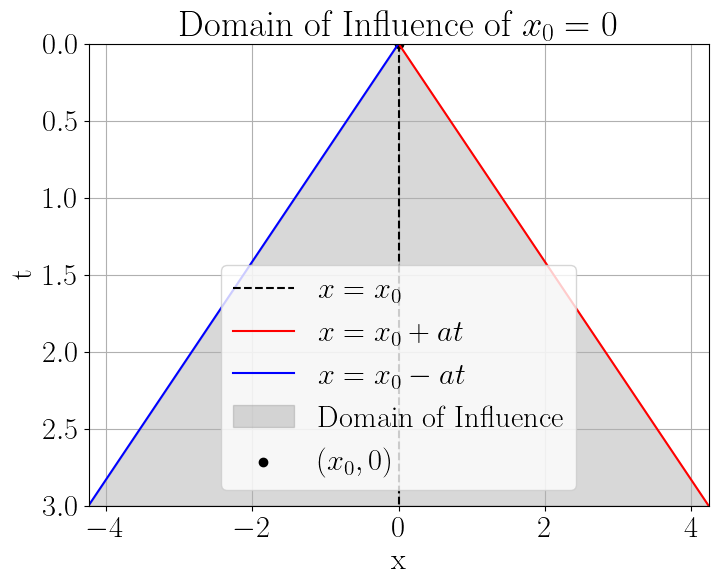

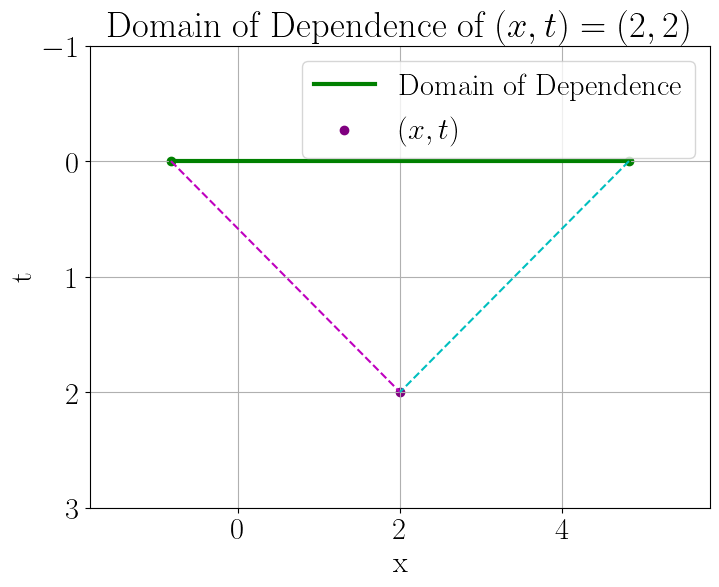

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a = np.sqrt(2)
x0 = 0  # Example point for domain of influence
x_point = 2  # Example x-coordinate for domain of dependence
t_point = 2  # Example t-coordinate for domain of dependence

# --- Domain of Influence ---
t_influence = np.linspace(0, 3, 100)
x_upper_influence = x0 + a * t_influence
x_lower_influence = x0 - a * t_influence

plt.figure(figsize=(8, 6))
plt.plot([x0, x0], [0, 3], 'k--', label='$x = x_0$')
plt.plot(x_upper_influence, t_influence, 'r-', label='$x = x_0 + at$')
plt.plot(x_lower_influence, t_influence, 'b-', label='$x = x_0 - at$')
plt.fill_betweenx(t_influence, x_lower_influence, x_upper_influence, color='gray', alpha=0.3, label='Domain of Influence')
plt.scatter(x0, 0, color='black', label='$(x_0, 0)$')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Domain of Influence of $x_0 = {x0}$')
plt.grid(True)
plt.legend()
plt.ylim(0, 3)
plt.xlim(x0 - 3*a, x0 + 3*a)
plt.gca().invert_yaxis() # To have time increasing upwards
plt.savefig('domain_of_influence.png')
plt.show()

# --- Domain of Dependence ---
x_dependence = np.linspace(x_point - a * t_point, x_point + a * t_point, 100)
t_dependence = np.zeros_like(x_dependence)

plt.figure(figsize=(8, 6))
plt.plot([x_point - a * t_point, x_point + a * t_point], [0, 0], 'g-', linewidth=3, label='Domain of Dependence')
plt.scatter(x_point, t_point, color='purple', label='$(x, t)$')
plt.scatter(x_point - a * t_point, 0, color='green')
plt.scatter(x_point + a * t_point, 0, color='green')
plt.plot([x_point - a * t_point, x_point], [0, t_point], 'm--')
plt.plot([x_point + a * t_point, x_point], [0, t_point], 'c--')
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Domain of Dependence of $(x, t) = ({x_point}, {t_point})$')
plt.grid(True)
plt.legend()
plt.ylim(-1, t_point + 1)
plt.xlim(x_point - a * t_point - 1, x_point + a * t_point + 1)
plt.gca().invert_yaxis() # To have time increasing upwards
plt.savefig('domain_of_dependence.png')
plt.show()